<img src="https://companieslogo.com/img/orig/kayak_BIG-48662c15.png?t=1701236680&download=true" alt="kayak logo" />

# Data Storage

### Import useful libraries

In [2]:
pip install python-dotenv psycopg2-binary sqlalchemy requests tqdm

Note: you may need to restart the kernel to use updated packages.


In [15]:
# Data manipulation
import pandas as pd
import numpy as np
import json
import glob

# Interaction with AWS S3
import boto3
from botocore.exceptions import ClientError

# Get secret access 
from dotenv import load_dotenv
import os

# Access to remote database
import psycopg2
from sqlalchemy import create_engine

import requests

# Time and progressor bar
import time
from tqdm import tqdm

# SQL queries
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
from sqlalchemy.sql import text

## Create data lake using S3

Before push all datas to S3, let's check if th datas are clean and ready to be pushed to S3

### results/hotels_data.json

In [14]:
# Import data from results folder
hotels_data = pd.read_json('results/booking_data.json')

# Display data
print("hotels_data")
display(hotels_data.head())
print()

# Verify if there's missing value in file
print(f"Checking for missing data in hotels_data file...")
display(hotels_data.isnull().any())
print()

# Delete rows with missing values in hotels_data file
print(f"Deleting rows with missing values in hotels_data file...")
hotels_data = hotels_data.dropna()
print("...Done")
print()

# Verify if there's duplicated data in hotels_data file
print(f"Checking for duplicated data in hotels_data file...")
display(hotels_data.duplicated().any())
print()

hotels_data


,name,score,description,latitude,longitude,url
0,Vivez le Bonheur - Plage - Port de plaisance -...,9.0,"Set in Le Havre, just less than 1 km from Le H...",49.488164,0.098942,https://www.booking.com/hotel/fr/nouveau-vivez...
1,The People Le Havre,8.5,"Welcome to The People Le Havre!\n\nHere, you c...",49.493422,0.130220,https://www.booking.com/hotel/fr/residence-la-...
2,L'Oasis Havrais - Centre Historique du Havre,8.6,"Located in Le Havre, near Le Volcan, Eglise St...",49.489258,0.111700,https://www.booking.com/hotel/fr/la-porte-ocea...
3,Appartement agréable et confortable pour 4 per...,8.5,"Set in Le Havre, just 2.9 km from Le Havre Bea...",49.498724,0.129134,https://www.booking.com/hotel/fr/bel-apparteme...
4,Vent des Grèves,9.2,"Featuring a garden and views of garden, Vent d...",48.615403,-1.491440,https://www.booking.com/hotel/fr/vent-des-grev...



Checking for missing data in hotels_data file...


name           False
score           True
description     True
latitude       False
longitude      False
url            False
dtype: bool


Deleting rows with missing values in hotels_data file...
...Done

Checking for duplicated data in hotels_data file...


np.False_

### results/destination_coordinates.csv

In [15]:
# Import data from results folder
weather_data = pd.read_csv("results/weather_data.csv")

# Display data
print("weather_data")
display(weather_data.head())
print()

# Verify if there's missing value in file
print(f"Checking for missing data in weather_data file...")
display(weather_data.isnull().any())
print()

weather_data


,city,lat,lon,temp_day,avg_temp,description
0,Mont Saint-Michel,48.635954,-1.511460,10.14,9.510000,pluie modérée
1,Saint-Malo,48.649518,-2.026041,10.43,8.468571,pluie modérée
2,Bayeux,49.276462,-0.702474,8.96,8.397143,pluie modérée
3,Le Havre,49.493898,0.107973,8.68,8.065714,pluie modérée
4,Rouen,49.440459,1.093966,9.59,9.188571,pluie modérée



Checking for missing data in weather_data file...


city           False
lat            False
lon            False
temp_day       False
avg_temp       False
description    False
dtype: bool

### results/destination_coordinates.csv

In [16]:
# Import data from results folder
destination_coordinates = pd.read_csv("results/destination_coordinates.csv")

# Display data
print("destination_coordinates")
display(destination_coordinates.head())
print()

# Verify if there's missing value in file
print(f"Checking for missing data in destination_coordinates file...")
display(destination_coordinates.isnull().any())
print()

# Verify if there's duplicated data in file
print(f"Checking for duplicated data in destination_coordinates file...")
display(destination_coordinates.duplicated().any())
print()

destination_coordinates


,destination,lat,lon
0,Mont Saint-Michel,48.635954,-1.511460
1,Saint-Malo,48.649518,-2.026041
2,Bayeux,49.276462,-0.702474
3,Le Havre,49.493898,0.107973
4,Rouen,49.440459,1.093966



Checking for missing data in destination_coordinates file...


destination    False
lat            False
lon            False
dtype: bool


Checking for duplicated data in destination_coordinates file...


np.False_

### results/destination_names.csv

In [17]:
# Import data from results folder
destination_names = pd.read_csv("results/destination_names.csv")

# Display data
print("destination_names")
display(destination_names.head())
print()

# Verify if there's missing value in file
print(f"Checking for missing data in destination_names file...")
display(destination_names.isnull().any())
print()

# Verify if there's duplicated data in file
print(f"Checking for duplicated data in destination_names file...")
display(destination_names.duplicated().any())

destination_names


,destination
0,Mont Saint Michel
1,St Malo
2,Bayeux
3,Le Havre
4,Rouen



Checking for missing data in destination_names file...


destination    False
dtype: bool


Checking for duplicated data in destination_names file...


np.False_

## AWS S3

### Connect to S3 bucket

In [6]:
# Load environnement variables
load_dotenv()

AWS_ACCESS_KEY_ID = os.getenv("AWS_ACCESS_KEY_ID")
AWS_SECRET_ACCESS_KEY = os.getenv("AWS_SECRET_ACCESS_KEY")
AWS_REGION = os.getenv("AWS_REGION")

In [19]:
session = boto3.Session(
    aws_access_key_id = AWS_ACCESS_KEY_ID,
    aws_secret_access_key = AWS_SECRET_ACCESS_KEY,
    region_name = "eu-west-3"
)

s3 = session.resource("s3")
s3_client = session.client("s3")


bucket_name = "block1-bucket"

# Check if bucket already exists
try :
    s3_client.head_bucket(Bucket=bucket_name)
    print(f"✅ Bucket already exists")
except ClientError as e :
    error_code = int(e.response['Error']['Code'])
    if error_code == "404":
        s3.create_bucket(
            Bucket=bucket_name,
            CreateBucketConfiguration={
                'LocationConstraint' : "eu-west-3"
            }
        )
    else :
        print("Error checking bucket")
        exit()

bucket = s3.Bucket(bucket_name)

✅ Bucket already exists


### Push all csv files

In [20]:
path = "C:/Users/arani/OneDrive/Documents/COURS/Projects/Project 5 - Web Scraping - Storage - ETL Processes/results"
extension = "csv"
result = glob.glob(os.path.join(path, f"*.{extension}"))

if not result:
    print(f"❌ No file  .{extension} found in '{path}'.")

for file in result :
    try :
        print("Upload :", file)
        # Keep only the file name
        filename = os.path.basename(file) 
        # Upload to S3 without subfolder structure
        bucket.upload_file(file, filename) 
    except Exception as e :
        print("Upload :", file, "failed")
        print(e)

Upload : C:/Users/arani/OneDrive/Documents/COURS/Projects/Project 5 - Web Scraping - Storage - ETL Processes/results\best_destinations.csv
Upload : C:/Users/arani/OneDrive/Documents/COURS/Projects/Project 5 - Web Scraping - Storage - ETL Processes/results\destination_coordinates.csv
Upload : C:/Users/arani/OneDrive/Documents/COURS/Projects/Project 5 - Web Scraping - Storage - ETL Processes/results\destination_names.csv
Upload : C:/Users/arani/OneDrive/Documents/COURS/Projects/Project 5 - Web Scraping - Storage - ETL Processes/results\weather_data.csv


### Modify json file before pushing on S3 bucket

In [21]:
print("Load json file ...")
json_file = open(f"{path}/booking_data.json")
booking_hotels_data = json.load(json_file)
print("...Done")
print()

hotels_df = pd.DataFrame(booking_hotels_data)
print(f"Shape of hotels_df : {hotels_df.shape}")
print()

display(hotels_df.head())
print()
print("Add city column in hotels_df")

# Add tolerance to match the coordinates details (in degrees)
tolerance = 0.01 # (~1km)

# Add progression bar
tqdm.pandas()

hotels_df['latitude'] = pd.to_numeric(hotels_df['latitude'], errors='coerce')
hotels_df['longitude'] = pd.to_numeric(hotels_df['longitude'], errors='coerce')
destination_coordinates['lat'] = pd.to_numeric(destination_coordinates['lat'], errors='coerce')
destination_coordinates['lon'] = pd.to_numeric(destination_coordinates['lon'], errors='coerce')

# Function to find city with latitude and longitude
def find_city(lat, lon) :
    match = destination_coordinates[
        (np.abs(destination_coordinates['lat'] - lat) <= tolerance) &
        (np.abs(destination_coordinates['lon'] - lon) <= tolerance)
    ]
    if not match.empty :
        return match.iloc[0]['destination']
    else :
        return None

# Apply this function on hotels_df
hotels_df['city'] = hotels_df.progress_apply(lambda row: find_city(row['latitude'], row['longitude']), axis=1)

display(hotels_df.head())
print()
print("Complete the missing cities with Nominatim")

# Function to find missing city
def reverse_geocode(lat, lon) :
    url_api = "https://nominatim.openstreetmap.org/reverse"
    headers = {
        "User-Agent" : "MyPythonScript/1.0",
        "Referer" : "https://mywebsite.com/page.html"
    }
    payload = {
        'lat' : lat,
        'lon' : lon,
        'format' : 'jsonv2',
        'zoom' : 10,
        'addressdetails' : 1
    }

    try :
        response = requests.get(url_api, params=payload, headers=headers)
        if response.status_code ==200:
            data = response.json()
            return data.get('address', {}).get('city') or \
                   data.get('address', {}).get('town') or \
                   data.get('address', {}).get('village')
        else :
            return None
    except Exception as e:
        print(f"API Error : {e}")
        return None
    
# Apply this function for missing cities
missing_city_rows = hotels_df[hotels_df['city'].isnull()]
for idx, row in tqdm(missing_city_rows.iterrows(), total=hotels_df['city'].isnull().sum()) :
    city = reverse_geocode(row['latitude'], row['longitude'])
    hotels_df.at[idx, 'city'] = city
    time.sleep(1)

display(hotels_df.head())

Load json file ...
...Done

Shape of hotels_df : (876, 6)



,name,score,description,latitude,longitude,url
0,Vivez le Bonheur - Plage - Port de plaisance -...,9,"Set in Le Havre, just less than 1 km from Le H...",49.488163827840836,0.09894180510142903,https://www.booking.com/hotel/fr/nouveau-vivez...
1,The People Le Havre,8.5,"Welcome to The People Le Havre!\n\nHere, you c...",49.4934219676408,0.13021990656852722,https://www.booking.com/hotel/fr/residence-la-...
2,L'Oasis Havrais - Centre Historique du Havre,8.6,"Located in Le Havre, near Le Volcan, Eglise St...",49.489258,0.11170000000000001,https://www.booking.com/hotel/fr/la-porte-ocea...
3,Appartement agréable et confortable pour 4 per...,8.5,"Set in Le Havre, just 2.9 km from Le Havre Bea...",49.498724448495,0.129134234943,https://www.booking.com/hotel/fr/bel-apparteme...
4,Vent des Grèves,9.2,"Featuring a garden and views of garden, Vent d...",48.615403,-1.49144,https://www.booking.com/hotel/fr/vent-des-grev...



Add city column in hotels_df


100%|██████████| 876/876 [00:00<00:00, 2702.18it/s]


,name,score,description,latitude,longitude,url,city
0,Vivez le Bonheur - Plage - Port de plaisance -...,9,"Set in Le Havre, just less than 1 km from Le H...",49.488164,0.098942,https://www.booking.com/hotel/fr/nouveau-vivez...,Le Havre
1,The People Le Havre,8.5,"Welcome to The People Le Havre!\n\nHere, you c...",49.493422,0.130220,https://www.booking.com/hotel/fr/residence-la-...,None
2,L'Oasis Havrais - Centre Historique du Havre,8.6,"Located in Le Havre, near Le Volcan, Eglise St...",49.489258,0.111700,https://www.booking.com/hotel/fr/la-porte-ocea...,Le Havre
3,Appartement agréable et confortable pour 4 per...,8.5,"Set in Le Havre, just 2.9 km from Le Havre Bea...",49.498724,0.129134,https://www.booking.com/hotel/fr/bel-apparteme...,None
4,Vent des Grèves,9.2,"Featuring a garden and views of garden, Vent d...",48.615403,-1.491440,https://www.booking.com/hotel/fr/vent-des-grev...,None



Complete the missing cities with Nominatim


100%|██████████| 339/339 [07:19<00:00,  1.30s/it]


,name,score,description,latitude,longitude,url,city
0,Vivez le Bonheur - Plage - Port de plaisance -...,9,"Set in Le Havre, just less than 1 km from Le H...",49.488164,0.098942,https://www.booking.com/hotel/fr/nouveau-vivez...,Le Havre
1,The People Le Havre,8.5,"Welcome to The People Le Havre!\n\nHere, you c...",49.493422,0.130220,https://www.booking.com/hotel/fr/residence-la-...,Le Havre
2,L'Oasis Havrais - Centre Historique du Havre,8.6,"Located in Le Havre, near Le Volcan, Eglise St...",49.489258,0.111700,https://www.booking.com/hotel/fr/la-porte-ocea...,Le Havre
3,Appartement agréable et confortable pour 4 per...,8.5,"Set in Le Havre, just 2.9 km from Le Havre Bea...",49.498724,0.129134,https://www.booking.com/hotel/fr/bel-apparteme...,Le Havre
4,Vent des Grèves,9.2,"Featuring a garden and views of garden, Vent d...",48.615403,-1.491440,https://www.booking.com/hotel/fr/vent-des-grev...,Pontorson


In [61]:
print("Rename latitude and longitude columns to lat and lon")
hotels_df.rename({'latitude' : 'lat', 'longitude' : 'lon'}, axis=1, inplace=True)
print()

print(f"Upload dataframe in {bucket_name}")
bucket.put_object(
    Body=hotels_df.to_csv(index=False),
    Key="hotels_data.csv"
)

print("Save hotels data in results folder")
hotels_df.to_csv("results/hotels_data.csv", index=False)

Rename latitude and longitude columns to lat and lon

Upload dataframe in block1-bucket
Save hotels data in results folder


### Show result on S3

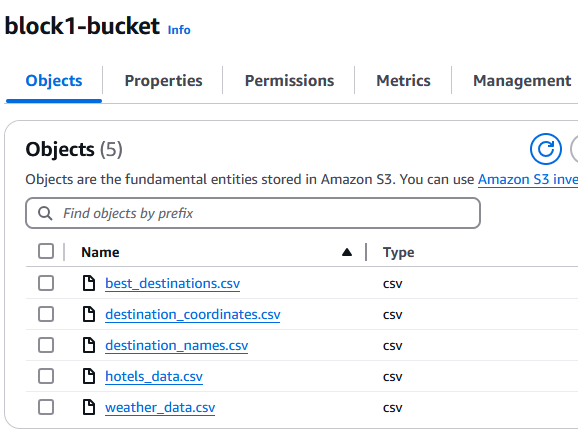

## AWS RDS

![Instance of database.png](<attachment:Instance of database.png>)
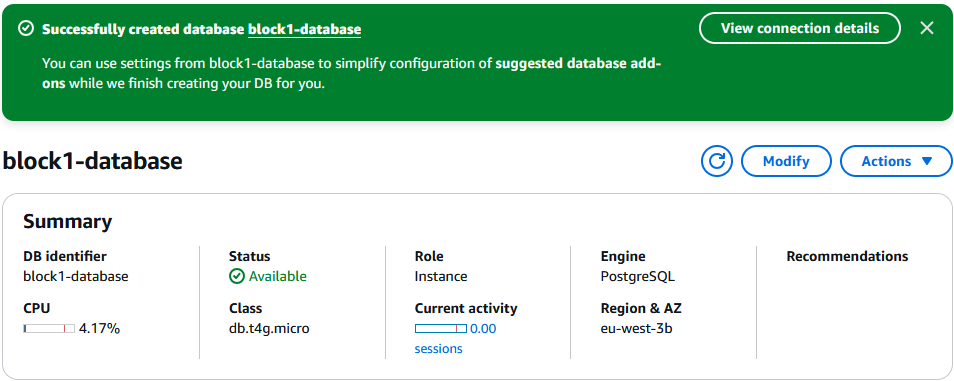

### PostgreSQL connection

In [7]:
DBHOST = os.getenv("DBHOST")
DBUSER = os.getenv("DBUSER")
DBPASS = os.getenv("DBPASS")
DBNAME = os.getenv("DBNAME")
PORT = os.getenv("PORT")

engine = create_engine(f"postgresql+psycopg2://{DBUSER}:{DBPASS}@{DBHOST}:{PORT}/{DBNAME}")

In [8]:
print(DBHOST, DBUSER, DBPASS, DBNAME, PORT)

block1-database.ch62668ycirk.eu-west-3.rds.amazonaws.com postgres Jedha-97411 block1-database 5432


### Read file from S3

In [9]:
# Versions incompatible of librairies need to read csv on local machine
destination_coordinates = pd.read_csv(
    "results/destination_coordinates.csv")
display(destination_coordinates.head())
print()

best_destinations = pd.read_csv("results/best_destinations.csv", index_col=0)
display(best_destinations.head())
print(f"Shape of best_destinations : {best_destinations.shape}")
print()

hotels_df = pd.read_csv("results/hotels_data.csv")
display(hotels_df.head())
print(f"Shape of hotels_df : {hotels_df.shape}")
print()

,destination,lat,lon
0,Mont Saint-Michel,48.635954,-1.511460
1,Saint-Malo,48.649518,-2.026041
2,Bayeux,49.276462,-0.702474
3,Le Havre,49.493898,0.107973
4,Rouen,49.440459,1.093966


,id,city,lat,lon,temp_day,avg_temp,description
0,0,Marseille,43.296174,5.369953,11.17,12.648571,ciel dégagé
1,1,Aix-en-Provence,43.529842,5.447474,10.31,12.132857,ciel dégagé
2,2,Bormes-les-Mimosas,43.150697,6.341928,12.00,12.097143,ciel dégagé
3,3,Cassis,43.214036,5.539632,10.26,12.090000,ciel dégagé
4,4,Collioure,42.525050,3.083155,14.51,11.931429,ciel dégagé


Shape of best_destinations : (7, 7)



,name,score,description,lat,lon,url,city
0,Vivez le Bonheur - Plage - Port de plaisance -...,9.0,"Set in Le Havre, just less than 1 km from Le H...",49.488164,0.098942,https://www.booking.com/hotel/fr/nouveau-vivez...,Le Havre
1,The People Le Havre,8.5,"Welcome to The People Le Havre!\n\nHere, you c...",49.493422,0.130220,https://www.booking.com/hotel/fr/residence-la-...,Le Havre
2,L'Oasis Havrais - Centre Historique du Havre,8.6,"Located in Le Havre, near Le Volcan, Eglise St...",49.489258,0.111700,https://www.booking.com/hotel/fr/la-porte-ocea...,Le Havre
3,Appartement agréable et confortable pour 4 per...,8.5,"Set in Le Havre, just 2.9 km from Le Havre Bea...",49.498724,0.129134,https://www.booking.com/hotel/fr/bel-apparteme...,Le Havre
4,Vent des Grèves,9.2,"Featuring a garden and views of garden, Vent d...",48.615403,-1.491440,https://www.booking.com/hotel/fr/vent-des-grev...,Pontorson


Shape of hotels_df : (876, 7)



### Now let's create our tables

In [10]:
# Create instances of best_destinations and best_hotels
Base = declarative_base()

# Define the Destination and Hotel tables using class
class Best_Destination(Base):
    __tablename__ = 'best_destinations'
    id = Column(Integer, primary_key=True)
    city = Column(String)
    lat = Column(Float)
    lon = Column(Float)
    temp_day = Column(Float)
    avg_temp = Column(Float)
    description = Column(String)

    hotels = relationship("Best_Hotel", back_populates="destination")

class Best_Hotel(Base):
    __tablename__ = "best_hotels"

    id = Column(Integer, primary_key=True, autoincrement=True)
    city = Column(String) 
    lat = Column(Float)
    lon = Column(Float)
    name = Column(String)
    score = Column(Float)
    description = Column(Text)
    url = Column(String)
    best_destination_id = Column(Integer, ForeignKey("best_destinations.id"))

    destination = relationship("Best_Destination", back_populates="hotels")

try:
    engine = create_engine(f"postgresql+psycopg2://{DBUSER}:{DBPASS}@{DBHOST}:{PORT}/{DBNAME}")
    Base.metadata.create_all(engine)
    print("Connection successful and tables created.")
except Exception as e:
    print(f"Error occurred: {e}")

# Create a session
Session = sessionmaker(bind=engine)
session = Session()

C:\Users\arani\AppData\Local\Temp\ipykernel_6456\2087053952.py:2: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


Connection successful and tables created.


### Insert data into the tables

In [11]:
def insert_best_destinations_from_csv(csv_file):
    # Read the CSV file
    df = pd.read_csv(csv_file)

    for _, row in df.iterrows():
        destination = Best_Destination(
            city=row["city"],
            lat=row["lat"],
            lon=row["lon"],
            temp_day=row["temp_day"],
            avg_temp=row["avg_temp"],
            description=row["description"],
            )
        session.add(destination)
    session.commit()
    print("Destinations data have been successfully inserted")

def insert_hotels_from_csv(csv_file):
    df = pd.read_csv(csv_file)

    for _, row in df.iterrows():
        # Trouver l'ID de la destination correspondante
        destination = session.query(Best_Destination).filter_by(city=row["city"]).first()
        
        if destination:
            hotel = Best_Hotel(
                city=row["city"],
                lat=row["lat"],
                lon=row["lon"],
                name=row["name"],
                score=row["score"],
                description=row["description"],
                url=row["url"],
                destination=destination,
            )
            session.add(hotel)
    session.commit()
    print("Hotels data have been successfully inserted")

# Insert data into the database
session.rollback() # Rollback the session to avoid conflicts
insert_best_destinations_from_csv("results/best_destinations.csv")
insert_hotels_from_csv("results/hotels_data.csv")

# Close SQLAlchemy session
session.close()

Destinations data have been successfully inserted
Hotels data have been successfully inserted


### Then, let's make some SQL queries to the database

We  need to show the top 5 of destinations below weather is "ciel dégagé" and the temperature is greater than 11°C.

In [18]:
# Create a connection to the database
conn = engine.connect()

# Query 1 : Select the top 5 of the best destinations
query1 = text("SELECT * FROM best_destinations ORDER BY temp_day DESC LIMIT 5")
result = conn.execute(query1)

print("Top 5 best destinations :")
for row in result:
    print(row)

Top 5 best destinations :
(5, 'Collioure', 42.52505, 3.0831554, 14.51, 11.93142857142857, 'ciel dégagé')
(12, 'Collioure', 42.52505, 3.0831554, 14.51, 11.93142857142857, 'ciel dégagé')
(6, 'Aigues-Mortes', 43.5661521, 4.19154, 12.48, 11.064285714285717, 'ciel dégagé')
(13, 'Aigues-Mortes', 43.5661521, 4.19154, 12.48, 11.064285714285717, 'ciel dégagé')
(7, 'Nîmes', 43.8374249, 4.3600687, 12.07, 11.027142857142858, 'ciel dégagé')


We need to show the top 20 of hotels below ranking score.

In [23]:
query2 = text("""
    SELECT * FROM (
        SELECT *, 
               ROW_NUMBER() OVER (PARTITION BY city ORDER BY score DESC) AS rank
        FROM best_hotels
        WHERE LOWER(city) IN (
            SELECT LOWER(city) FROM best_destinations ORDER BY temp_day DESC LIMIT 5
        )
    ) AS ranked_hotels
    WHERE rank <= 20
    ORDER BY city, score DESC;
""")

result2 = conn.execute(query2)

print("\nTop 20 best hotels per city in the top 5 destinations:")
for row in result2:
    print(row)




Top 20 best hotels per city in the top 5 destinations:
(284, 'Aigues-Mortes', 43.5676511, 4.1915496, 'Maison cosy, 2 chambres, adossée aux remparts', 9.7, 'Situated in Aigues-Mortes in the Languedoc-Roussillon region, Maison cosy, 2 chambres, adossée aux remparts has a terrace. The property is around 24  ... (446 characters truncated) ... \nMontpellier Town Hall is 31 km from the holiday home, while The Corum is 32 km from the property. Montpellier - Mediterranee Airport is 29 km away.', 'https://www.booking.com/hotel/fr/maison-cosy-2-chambres-adossee-aux-remparts.en-gb.html?aid=304142&label=gen173nr-1FCAQoggJCFHNlYXJjaF9haWd1ZXMgbW9yd ... (158 characters truncated) ... dults=2&no_rooms=1&group_children=0&req_children=0&hpos=22&hapos=22&sr_order=popularity&srpvid=916b8b4adaa1039f&srepoch=1740685717&from=searchresults', 6, 1)
(109, 'Aigues-Mortes', 43.5676511, 4.1915496, 'Maison cosy, 2 chambres, adossée aux remparts', 9.7, 'Situated in Aigues-Mortes in the Languedoc-Roussillon region,